# Deep Neural Network (DNN) to estimate route flows from counts on a road network
### Requires counts of flows on edges in the road network
### Requires road network as Networkx (OSMnX) object

# DNN uses a complete set of counts as inputs (dim Nt x I) and produces route flow X as output (dim Nt x J)
- Nt is the number of time slices available in the data (usually aggregations of 15 mins each, 4 slices per hour)
- I is the number of edges with counts
- J is the total number of routes through the network between Origin-Destination (OD) pairs (aij <-> adjacency matrix method)
- J can also be the number of OD pairs (P_mat <-> finite memory Markov method)
- One instance is a Y (counts) vector as input and a X (route flow) output vector
- Pytorch treats each line of data as an instance
- Therefore I need to transpose the I x Nt and J x Nt and aij from the papers to: Nt x I = Nt x J @ aij.T and use DataLoader

### Implement Dey, et al. toy model from Figure 1
- Subrasankha Dey, Stephen Winter and Martin Tomko, Origin-Destination Flow Estimation from Link Count Data Only, Sensors 2020, 20, 5226.
### Compare output with workbook CompressionSensing_7.ipynb

@article{diamond2016cvxpy,
  author  = {Steven Diamond and Stephen Boyd},
  title   = {{CVXPY}: {A} {P}ython-embedded modeling language for convex optimization},
  journal = {Journal of Machine Learning Research},
  year    = {2016},
  volume  = {17},
  number  = {83},
  pages   = {1--5},
}

# Issues: MLP gives many 0-value route flows
- See bottom for test results

# Use final_proj_torch environment
-cvxpy
-osmnx
-pytorch
-geopandas

In [1]:
import numpy as np
import cvxpy as cvx
import geopandas as gp
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [56]:
import os
import errno
data_dir = "../"
print("Data directory ",data_dir)
path = os.path.join(data_dir,"output")

try:
    os.mkdir(path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
print("Created directory "+path)

Data directory  ../
Created directory ../output


# Toy model from Figure 1 in Dey(2020)
- 6 nodes in 3x2 grid
- All are O and D (12 relations)
- 7 directed one-way edges
- Multiple routes per OD relation (16 total)
- Test my implementation of the P matrix

In [3]:
nodes=["A","B","C","D","E","F"]# node names
edges=["AB","AD","DE","EF","BC","BE","CF"]#edge names
edge_uv=[("A","B"),("A","D"),("D","E"),("E","F"),("B","C"),("B","E"),("C","F")]# node names u,v
edge_weights=[1,1,1,1,1,1,1]
edge_weights_dict=dict(zip(edge_uv,edge_weights))
edge_labels_dict = dict(zip(edges, edge_uv))
node_xy=[(0,0),(1,0),(2,0),(0,1),(1,1),(2,1)]
node_xy_dict=dict(zip(nodes,node_xy))

In [4]:
edge_weights_dict

{('A', 'B'): 1,
 ('A', 'D'): 1,
 ('D', 'E'): 1,
 ('E', 'F'): 1,
 ('B', 'C'): 1,
 ('B', 'E'): 1,
 ('C', 'F'): 1}

In [5]:
edge_labels_dict

{'AB': ('A', 'B'),
 'AD': ('A', 'D'),
 'DE': ('D', 'E'),
 'EF': ('E', 'F'),
 'BC': ('B', 'C'),
 'BE': ('B', 'E'),
 'CF': ('C', 'F')}

In [6]:
node_xy_dict

{'A': (0, 0), 'B': (1, 0), 'C': (2, 0), 'D': (0, 1), 'E': (1, 1), 'F': (2, 1)}

# Make a networkx object of the graph

In [7]:
G=nx.DiGraph()
G.graph["name"]="Model 1 Hazelton(2015)"
G.add_nodes_from(nodes)
nx.set_node_attributes(G,node_xy_dict,name="pos")
G.add_edges_from(edge_uv)#add_weighted_edges_from (3,1,5.493) tuple u,v,weight
nx.set_edge_attributes(G,edge_weights_dict,name="weight")
print(G.number_of_nodes(), G.number_of_edges())
print(list(G.nodes))
print(list(G.edges))
#G.adj.items#
#G.edges.data# for (u, v, wt) in FG.edges.data('weight'):
print(list(G.neighbors("A")))

6 7
['A', 'B', 'C', 'D', 'E', 'F']
[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'F'), ('D', 'E'), ('E', 'F')]
['B', 'D']


In [8]:
print(nx.get_node_attributes(G,"pos"))

{'A': (0, 0), 'B': (1, 0), 'C': (2, 0), 'D': (0, 1), 'E': (1, 1), 'F': (2, 1)}


In [9]:
print(nx.get_edge_attributes(G,"weight"))

{('A', 'B'): 1, ('A', 'D'): 1, ('B', 'C'): 1, ('B', 'E'): 1, ('C', 'F'): 1, ('D', 'E'): 1, ('E', 'F'): 1}


In [10]:
list(nx.all_simple_paths(G,"A","D"))

[['A', 'D']]

# Plot only shows weights of one link if links are parallel
- for better plots use graphvis or ox

{('A', 'B'): Text(0.5, 0.0, '1'),
 ('A', 'D'): Text(0.0, 0.5, '1'),
 ('B', 'C'): Text(1.5, 0.0, '1'),
 ('B', 'E'): Text(1.0, 0.5, '1'),
 ('C', 'F'): Text(2.0, 0.5, '1'),
 ('D', 'E'): Text(0.5, 1.0, '1'),
 ('E', 'F'): Text(1.5, 1.0, '1')}

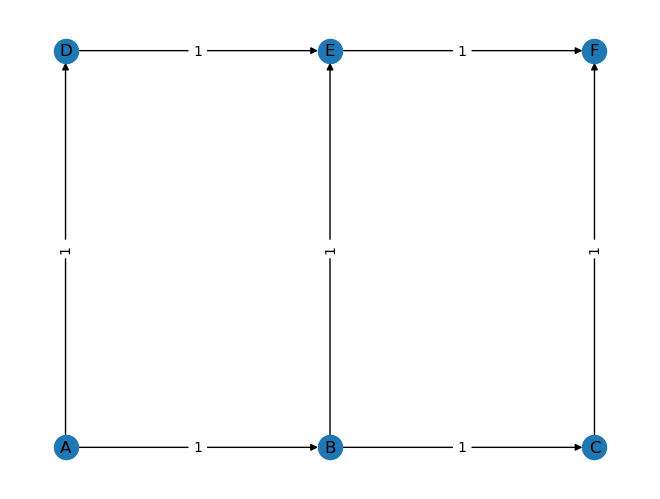

In [11]:
pos=nx.get_node_attributes(G,"pos")
nx.draw(G,pos,with_labels=True)
labels = nx.get_edge_attributes(G,"weight")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#subax2=plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')


# $Y_i$

In [12]:
counts=np.zeros((7,5))# rows are links with counts, columns are counts in a time interval
counts[0,:]=[255,190,220,190,235]# edge 1
counts[1,:]=[85,78,80,77,79]# no counts for edge 2
counts[2,:]=[235,181,186,176,195]# edge 3
counts[3,:]=[210,165,180,175,190]# edge 4
counts[4,:]=[56,42,48,56,58]# edge 5
counts[5,:]=[78,74,87,80,83]# edge 6
counts[6,:]=[78,74,87,80,83]# edge 7
countkeys=edge_labels_dict.values()
counts_dict=dict(zip(countkeys,counts[:,:]))

In [13]:
print(countkeys)

dict_values([('A', 'B'), ('A', 'D'), ('D', 'E'), ('E', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F')])


In [14]:
counts_dict

{('A', 'B'): array([255., 190., 220., 190., 235.]),
 ('A', 'D'): array([85., 78., 80., 77., 79.]),
 ('D', 'E'): array([235., 181., 186., 176., 195.]),
 ('E', 'F'): array([210., 165., 180., 175., 190.]),
 ('B', 'C'): array([56., 42., 48., 56., 58.]),
 ('B', 'E'): array([78., 74., 87., 80., 83.]),
 ('C', 'F'): array([78., 74., 87., 80., 83.])}

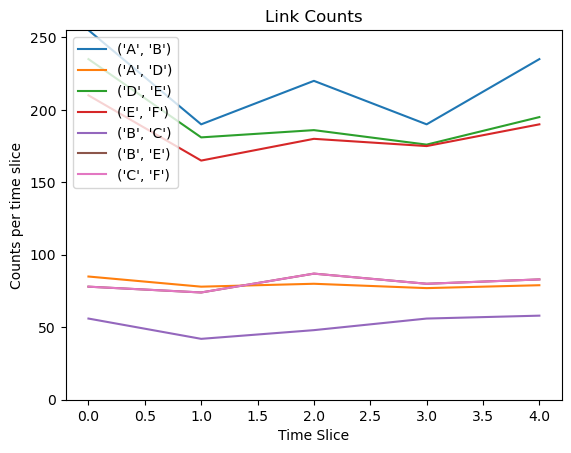

In [15]:
import matplotlib.pyplot as plt
x=list(range(0,counts.shape[1]))
for ii in range(counts.shape[0]):
    plt.plot(x,counts[ii,:],label=str(list(counts_dict.keys())[ii]))
plt.ylim(0,np.max(counts))
plt.xlabel("Time Slice")
plt.ylabel("Counts per time slice")
plt.legend()
plt.title("Link Counts")
plt.show()

# Routes between O's and D's.
- one list of routes as edge sequences
- one list of routes as node sequences
- note that a dict of OD_pairs to routes must accomodate several routes per OD_pair later on
    - the "zip" can be replaced by an iterator over OD_Pairs, add a list of routes to the OD_Pair key

# $O, D$

In [16]:
origins=origins=nodes#["A"]#nodes
destinations=nodes#["F"]
od_pairs=[]
for o in origins:
   for d in nx.dfs_postorder_nodes(G,source=o):
    if((o!=d) and (d in destinations)):
        od_pairs.append((o,d))
print(od_pairs)
print(len(od_pairs))

[('A', 'F'), ('A', 'C'), ('A', 'E'), ('A', 'B'), ('A', 'D'), ('B', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F'), ('D', 'F'), ('D', 'E'), ('E', 'F')]
12


In [17]:
od_route_n_dict={}
od_route_e_dict={}

In [18]:
# routes as sequence of nodes
routes_n=[]
routes_e=[]
for od in od_pairs:
    rnlist=list(nx.all_simple_paths(G,od[0],od[1]))
    od_route_n_dict[od]=rnlist
    routes_n.append(rnlist)
    relist=list(nx.all_simple_edge_paths(G,od[0],od[1]))
    od_route_e_dict[od]=relist
    routes_e.append(relist)

In [19]:
len(routes_e)

12

In [20]:
od_route_n_dict

{('A', 'F'): [['A', 'B', 'C', 'F'],
  ['A', 'B', 'E', 'F'],
  ['A', 'D', 'E', 'F']],
 ('A', 'C'): [['A', 'B', 'C']],
 ('A', 'E'): [['A', 'B', 'E'], ['A', 'D', 'E']],
 ('A', 'B'): [['A', 'B']],
 ('A', 'D'): [['A', 'D']],
 ('B', 'F'): [['B', 'C', 'F'], ['B', 'E', 'F']],
 ('B', 'C'): [['B', 'C']],
 ('B', 'E'): [['B', 'E']],
 ('C', 'F'): [['C', 'F']],
 ('D', 'F'): [['D', 'E', 'F']],
 ('D', 'E'): [['D', 'E']],
 ('E', 'F'): [['E', 'F']]}

In [21]:
od_route_e_dict

{('A', 'F'): [[('A', 'B'), ('B', 'C'), ('C', 'F')],
  [('A', 'B'), ('B', 'E'), ('E', 'F')],
  [('A', 'D'), ('D', 'E'), ('E', 'F')]],
 ('A', 'C'): [[('A', 'B'), ('B', 'C')]],
 ('A', 'E'): [[('A', 'B'), ('B', 'E')], [('A', 'D'), ('D', 'E')]],
 ('A', 'B'): [[('A', 'B')]],
 ('A', 'D'): [[('A', 'D')]],
 ('B', 'F'): [[('B', 'C'), ('C', 'F')], [('B', 'E'), ('E', 'F')]],
 ('B', 'C'): [[('B', 'C')]],
 ('B', 'E'): [[('B', 'E')]],
 ('C', 'F'): [[('C', 'F')]],
 ('D', 'F'): [[('D', 'E'), ('E', 'F')]],
 ('D', 'E'): [[('D', 'E')]],
 ('E', 'F'): [[('E', 'F')]]}

In [22]:
od_route_names_dict={}
route_names=[]
for od in od_pairs:
    od_route_names=[]
    for i in range(0,len(od_route_n_dict[od])):
        string=((od[0],od[1],str(i)))
        od_route_names.append(string)
        route_names.append(string)
    od_route_names_dict[od]=tuple(od_route_names)


In [23]:
route_names

[('A', 'F', '0'),
 ('A', 'F', '1'),
 ('A', 'F', '2'),
 ('A', 'C', '0'),
 ('A', 'E', '0'),
 ('A', 'E', '1'),
 ('A', 'B', '0'),
 ('A', 'D', '0'),
 ('B', 'F', '0'),
 ('B', 'F', '1'),
 ('B', 'C', '0'),
 ('B', 'E', '0'),
 ('C', 'F', '0'),
 ('D', 'F', '0'),
 ('D', 'E', '0'),
 ('E', 'F', '0')]

In [24]:
len(route_names)

16

In [25]:
od_route_names_dict

{('A', 'F'): (('A', 'F', '0'), ('A', 'F', '1'), ('A', 'F', '2')),
 ('A', 'C'): (('A', 'C', '0'),),
 ('A', 'E'): (('A', 'E', '0'), ('A', 'E', '1')),
 ('A', 'B'): (('A', 'B', '0'),),
 ('A', 'D'): (('A', 'D', '0'),),
 ('B', 'F'): (('B', 'F', '0'), ('B', 'F', '1')),
 ('B', 'C'): (('B', 'C', '0'),),
 ('B', 'E'): (('B', 'E', '0'),),
 ('C', 'F'): (('C', 'F', '0'),),
 ('D', 'F'): (('D', 'F', '0'),),
 ('D', 'E'): (('D', 'E', '0'),),
 ('E', 'F'): (('E', 'F', '0'),)}

### Have to flatten the routes_e and routes_n lists in order to assign them to route_names

In [26]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [27]:
print(len(flatten(routes_e)))

16


In [28]:
# dict of origins and routes
routes_e_dict=dict(zip(route_names,flatten(routes_e)))# route names, edge sequence (tuple u,v)
routes_n_dict=dict(zip(route_names,flatten(routes_n)))# route names, node sequence (u)

In [29]:
routes_e_dict

{('A', 'F', '0'): [('A', 'B'), ('B', 'C'), ('C', 'F')],
 ('A', 'F', '1'): [('A', 'B'), ('B', 'E'), ('E', 'F')],
 ('A', 'F', '2'): [('A', 'D'), ('D', 'E'), ('E', 'F')],
 ('A', 'C', '0'): [('A', 'B'), ('B', 'C')],
 ('A', 'E', '0'): [('A', 'B'), ('B', 'E')],
 ('A', 'E', '1'): [('A', 'D'), ('D', 'E')],
 ('A', 'B', '0'): [('A', 'B')],
 ('A', 'D', '0'): [('A', 'D')],
 ('B', 'F', '0'): [('B', 'C'), ('C', 'F')],
 ('B', 'F', '1'): [('B', 'E'), ('E', 'F')],
 ('B', 'C', '0'): [('B', 'C')],
 ('B', 'E', '0'): [('B', 'E')],
 ('C', 'F', '0'): [('C', 'F')],
 ('D', 'F', '0'): [('D', 'E'), ('E', 'F')],
 ('D', 'E', '0'): [('D', 'E')],
 ('E', 'F', '0'): [('E', 'F')]}

In [30]:
routes_n_dict

{('A', 'F', '0'): ['A', 'B', 'C', 'F'],
 ('A', 'F', '1'): ['A', 'B', 'E', 'F'],
 ('A', 'F', '2'): ['A', 'D', 'E', 'F'],
 ('A', 'C', '0'): ['A', 'B', 'C'],
 ('A', 'E', '0'): ['A', 'B', 'E'],
 ('A', 'E', '1'): ['A', 'D', 'E'],
 ('A', 'B', '0'): ['A', 'B'],
 ('A', 'D', '0'): ['A', 'D'],
 ('B', 'F', '0'): ['B', 'C', 'F'],
 ('B', 'F', '1'): ['B', 'E', 'F'],
 ('B', 'C', '0'): ['B', 'C'],
 ('B', 'E', '0'): ['B', 'E'],
 ('C', 'F', '0'): ['C', 'F'],
 ('D', 'F', '0'): ['D', 'E', 'F'],
 ('D', 'E', '0'): ['D', 'E'],
 ('E', 'F', '0'): ['E', 'F']}

In [31]:
edge_labels_dict

{'AB': ('A', 'B'),
 'AD': ('A', 'D'),
 'DE': ('D', 'E'),
 'EF': ('E', 'F'),
 'BC': ('B', 'C'),
 'BE': ('B', 'E'),
 'CF': ('C', 'F')}

In [32]:
# route costs
routes_c_dict={}
for rn in route_names:
    es=routes_e_dict[rn]
    lc=[]
    for e in es:
        c=edge_weights_dict[e]
        lc.append(c)
    routes_c_dict[rn]=lc
print(routes_c_dict)

{('A', 'F', '0'): [1, 1, 1], ('A', 'F', '1'): [1, 1, 1], ('A', 'F', '2'): [1, 1, 1], ('A', 'C', '0'): [1, 1], ('A', 'E', '0'): [1, 1], ('A', 'E', '1'): [1, 1], ('A', 'B', '0'): [1], ('A', 'D', '0'): [1], ('B', 'F', '0'): [1, 1], ('B', 'F', '1'): [1, 1], ('B', 'C', '0'): [1], ('B', 'E', '0'): [1], ('C', 'F', '0'): [1], ('D', 'F', '0'): [1, 1], ('D', 'E', '0'): [1], ('E', 'F', '0'): [1]}


# Adjacency matrix (link-path incidence matrix) A=aij
- counted edges/links versus routes they are on
- 0,1 definition used by Vardi(1996) and Hazelton(2015)
- Make into a function
- This should be OD relations to the right and not routes
    - if there are more than 1 routes per OD relation this code has to be fixed, see later on
- It's still a valuable mapping to have

In [33]:
# a_ij = 1 if link i is in route j, 0 otherwise
I=len(counts_dict)#7
J=len(routes_e)#16
aij=np.zeros((I, J))
for i in range(I):
    for j in range(J):
        for k in range(len(routes_e[j])):
            print(routes_e[j][k])
            print(list(counts_dict.keys())[i])
            if(routes_e[j][k]==list(counts_dict.keys())[i]):
                aij[i,j]=1

[('A', 'B'), ('B', 'C'), ('C', 'F')]
('A', 'B')
[('A', 'B'), ('B', 'E'), ('E', 'F')]
('A', 'B')
[('A', 'D'), ('D', 'E'), ('E', 'F')]
('A', 'B')
[('A', 'B'), ('B', 'C')]
('A', 'B')
[('A', 'B'), ('B', 'E')]
('A', 'B')
[('A', 'D'), ('D', 'E')]
('A', 'B')
[('A', 'B')]
('A', 'B')
[('A', 'D')]
('A', 'B')
[('B', 'C'), ('C', 'F')]
('A', 'B')
[('B', 'E'), ('E', 'F')]
('A', 'B')
[('B', 'C')]
('A', 'B')
[('B', 'E')]
('A', 'B')
[('C', 'F')]
('A', 'B')
[('D', 'E'), ('E', 'F')]
('A', 'B')
[('D', 'E')]
('A', 'B')
[('E', 'F')]
('A', 'B')
[('A', 'B'), ('B', 'C'), ('C', 'F')]
('A', 'D')
[('A', 'B'), ('B', 'E'), ('E', 'F')]
('A', 'D')
[('A', 'D'), ('D', 'E'), ('E', 'F')]
('A', 'D')
[('A', 'B'), ('B', 'C')]
('A', 'D')
[('A', 'B'), ('B', 'E')]
('A', 'D')
[('A', 'D'), ('D', 'E')]
('A', 'D')
[('A', 'B')]
('A', 'D')
[('A', 'D')]
('A', 'D')
[('B', 'C'), ('C', 'F')]
('A', 'D')
[('B', 'E'), ('E', 'F')]
('A', 'D')
[('B', 'C')]
('A', 'D')
[('B', 'E')]
('A', 'D')
[('C', 'F')]
('A', 'D')
[('D', 'E'), ('E', 'F')]
('A

In [34]:
I=len(countkeys)
J=len(route_names)
aij=np.zeros((I,J))
i=0
for e in countkeys:#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if(e == r):
                aij[i,j]=1
        j+=1
    i+=1
        

In [35]:
aij# each column is a route between an OD pair J and each row has 1 if a link I is on the route

array([[1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

# Matrix of all edges which are on routes a2ij
- Map of all edges/links and the routes they are on
- 0,1
- Use to calculate the flows on non-measured links along the routes
- After the OD flows are calculated

In [36]:
edge_labels_dict.values()

dict_values([('A', 'B'), ('A', 'D'), ('D', 'E'), ('E', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F')])

In [37]:
I=len(edge_labels_dict.keys())
J=len(route_names)
a2ij=np.zeros((I,J))
pi1=np.zeros((I,J))
i=0
for e in edge_labels_dict.values():#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if(e == r):
                a2ij[i,j]=1
                pi1[i,j]=edge_weights[i]
        j+=1
    i+=1

In [38]:
a2ij

array([[1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

### For each time slice, Y is counts (dim m x 1) = A (dim m x n) * X (dim n x 1), m<n .
- Need to find X the OD flow
- m is the number of edges with counts on them
- n is the number of routes between OD
- dimension 1 becomes K for K time slices

In [39]:
print(aij.shape, counts.shape)

(7, 16) (7, 5)


# Model 5 days of made-up data on 7 (all links) measured links for all 16 routes (each OD pair has different number of routes). Flows are per route, not per OD

- Hazelton (2015) must use a survey of OD traffic to generate initial x flows using a Gamma function of parameters (x_survey/2, 1/2). How does he use these in the solution?

- The following is solved using ECOS_BB in the package cvxpy

### We need integer-value results and use a special included mixed-integer solver

In [40]:
# y = Ax
# We have y and A and want x
# y is m x 1; A is m x n; x is n x 1; m = 5, n = 6
x = cvx.Variable((aij.shape[1],counts.shape[1]),integer=True)

#err = cvx.abs(aij @ x - counts)
err = cvx.sum_squares(aij @ x - counts)
objective = cvx.Minimize(cvx.norm(err,1))# regularize later with sum(w*aij) see Kurzhanskiy
constraints = [x >= 0 ]
prob = cvx.Problem(objective, constraints)

# The optimal objective is returned by prob.solve().
result = prob.solve(solver="ECOS_BB")

# The optimal value for x is stored in x.value.
print("The flows on the routes (one route per row) in the time slices (one time slice per column)")
print(x.value)

The flows on the routes (one route per row) in the time slices (one time slice per column)
[[9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
  1.20000000e+01]
 [1.50000000e+01 1.40000000e+01 1.60000000e+01 1.40000000e+01
  1.50000000e+01]
 [2.00000000e+01 1.70000000e+01 1.80000000e+01 1.70000000e+01
  1.80000000e+01]
 [1.90000000e+01 1.00000000e+01 1.20000000e+01 1.40000000e+01
  1.50000000e+01]
 [2.00000000e+01 1.90000000e+01 2.20000000e+01 2.00000000e+01
  2.10000000e+01]
 [2.80000000e+01 2.50000000e+01 2.60000000e+01 2.50000000e+01
  2.60000000e+01]
 [2.01000000e+02 1.38000000e+02 1.61000000e+02 1.30000000e+02
  1.73000000e+02]
 [3.70000000e+01 3.50000000e+01 3.60000000e+01 3.50000000e+01
  3.50000000e+01]
 [1.60000000e+01 1.00000000e+01 1.20000000e+01 1.30000000e+01
  1.40000000e+01]
 [1.80000000e+01 1.70000000e+01 2.00000000e+01 1.90000000e+01
  2.00000000e+01]
 [2.10000000e+01 1.30000000e+01 1.40000000e+01 1.80000000e+01
  1.80000000e+01]
 [2.40000000e+01 2.40000000e+

c:\Users\jkhac\anaconda3\envs\final_proj_torch\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [41]:
print(np.mean(x.value,axis=1))

[  8.4  14.8  18.   14.   20.4  26.  160.6  35.6  13.   18.8  16.8  26.2
  59.2  43.4 107.   89. ]


In [42]:
print(f"{np.array2string(np.mean(x.value,axis=1),precision=1, floatmode='fixed')}")
print(f"{np.array2string(np.std(x.value,axis=1),precision=1, floatmode='fixed')}")
print(np.sum(np.mean(x.value,axis=1)))

[  8.4  14.8  18.0  14.0  20.4  26.0 160.6  35.6  13.0  18.8  16.8  26.2
  59.2  43.4 107.0  89.0]
[ 4.3  0.7  1.1  3.0  1.0  1.1 25.4  0.8  2.0  1.2  2.9  1.9  3.8  5.1
 14.1  8.9]
671.2000000000274


In [43]:
print(od_route_names_dict)
my_dict=od_route_names_dict
name=route_names[0]
print(name)
#value = {i for i in od_route_names_dict if od_route_names_dict[i]==name}
#print("key by value:",value)
key = list(filter(lambda x: my_dict[x] == name, my_dict))
print(key)

{('A', 'F'): (('A', 'F', '0'), ('A', 'F', '1'), ('A', 'F', '2')), ('A', 'C'): (('A', 'C', '0'),), ('A', 'E'): (('A', 'E', '0'), ('A', 'E', '1')), ('A', 'B'): (('A', 'B', '0'),), ('A', 'D'): (('A', 'D', '0'),), ('B', 'F'): (('B', 'F', '0'), ('B', 'F', '1')), ('B', 'C'): (('B', 'C', '0'),), ('B', 'E'): (('B', 'E', '0'),), ('C', 'F'): (('C', 'F', '0'),), ('D', 'F'): (('D', 'F', '0'),), ('D', 'E'): (('D', 'E', '0'),), ('E', 'F'): (('E', 'F', '0'),)}
('A', 'F', '0')
[]


In [44]:
## Make OD flows out of the route flows by summing over route flows for each OD

def od_flow_from_route_flow(od_pairs, route_flows):
    
 # Make OD flows out of the route flows by summing over route flows for each OD
    I=x.value.shape[1]
    J=len(od_pairs)
    j=0
    i_r=0
    od_flow=np.zeros((I))
    od_flow_matrix=np.zeros((J,I))
    for od in od_pairs:
        od_flow=0
        rs=od_route_names_dict[od]
        for r in rs:
            od_flow=od_flow+route_flows[i_r,:]
            print(j,i_r,r,od_flow, route_flows[i_r,:])
            i_r+=1
        od_flow_matrix[j,:]=od_flow
        j+=1
    return(od_flow_matrix)

In [45]:
od_flow_matrix_x=od_flow_from_route_flow(od_pairs,x.value)
print(od_flow_matrix_x)

0 0 ('A', 'F', '0') [9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
 1.20000000e+01] [9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
 1.20000000e+01]
0 1 ('A', 'F', '1') [15. 23. 26. 25. 27.] [15. 14. 16. 14. 15.]
0 2 ('A', 'F', '2') [35. 40. 44. 42. 45.] [20. 17. 18. 17. 18.]
1 3 ('A', 'C', '0') [19. 10. 12. 14. 15.] [19. 10. 12. 14. 15.]
2 4 ('A', 'E', '0') [20. 19. 22. 20. 21.] [20. 19. 22. 20. 21.]
2 5 ('A', 'E', '1') [48. 44. 48. 45. 47.] [28. 25. 26. 25. 26.]
3 6 ('A', 'B', '0') [201. 138. 161. 130. 173.] [201. 138. 161. 130. 173.]
4 7 ('A', 'D', '0') [37. 35. 36. 35. 35.] [37. 35. 36. 35. 35.]
5 8 ('B', 'F', '0') [16. 10. 12. 13. 14.] [16. 10. 12. 13. 14.]
5 9 ('B', 'F', '1') [34. 27. 32. 32. 34.] [18. 17. 20. 19. 20.]
6 10 ('B', 'C', '0') [21. 13. 14. 18. 18.] [21. 13. 14. 18. 18.]
7 11 ('B', 'E', '0') [24. 24. 29. 27. 27.] [24. 24. 29. 27. 27.]
8 12 ('C', 'F', '0') [62. 55. 65. 56. 58.] [62. 55. 65. 56. 58.]
9 13 ('D', 'F', '0') [53. 39. 41. 40. 44.] 

In [46]:
print(f"{np.array2string(np.mean(od_flow_matrix_x,axis=1),precision=1, floatmode='fixed')}")
print(f"{np.array2string(np.std(od_flow_matrix_x,axis=1),precision=1, floatmode='fixed')}")
print(np.sum(np.mean(x.value,axis=1)))

[ 41.2  14.0  46.4 160.6  35.6  31.8  16.8  26.2  59.2  43.4 107.0  89.0]
[ 3.5  3.0  1.6 25.4  0.8  2.6  2.9  1.9  3.8  5.1 14.1  8.9]
671.2000000000274


In [47]:
#np.set_printoptions(suppress=True)
#print(od_flow_matrix_x)

In [48]:
print("The flows on each edge (one edge per row) (one time slice per column")
print("NOTE that all flows equal counts and that edge 5 flows have been imputed by the algorithm")
np.dot(a2ij,x.value)

The flows on each edge (one edge per row) (one time slice per column
NOTE that all flows equal counts and that edge 5 flows have been imputed by the algorithm


array([[255., 190., 221., 189., 236.],
       [ 85.,  77.,  80.,  77.,  79.],
       [235., 180., 186., 176., 195.],
       [210., 165., 180., 175., 190.],
       [ 56.,  42.,  48.,  56.,  59.],
       [ 77.,  74.,  87.,  80.,  83.],
       [ 78.,  74.,  87.,  80.,  84.]])

# Try first model using aij incidence matrix rather than the Markov transition matrix of Dey

In [49]:
import torch
from torch import nn
torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

Using cuda device


# First model is an MLP

In [50]:
# Set run hyperparameters
# Set fixed random number seed
torch.manual_seed(42)
lrate=1e-6#1e-4
l1size=256#256
l2size=256#256
n_epochs=3000#50
l1_lambda=0.01#.01
J=aij.shape[1]# J is number of routes
I=aij.shape[0]# I is the number of edges with counts
Nt=counts.shape[1]# Nt is number of time slices
xsize=J# X output is number of routes x number of time slices
ysize=I# Number of links with counts
plttitle="MLP Model 1 Dey w/ simulated counts: "

# Note that at each instance we input 7 values and expect to generate 16 values

In [51]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Initialize input weights
def w0_(size):
  w0 = size[0]
  weight= 1./np.sqrt(w0)
  #weight=1/w0
 # print(f"w0 weights {weight}")
  w0_matrix=torch.Tensor(size).uniform_(-weight,weight)
 # print(f"init weight matrix {w0_matrix.cpu()}")
  return w0_matrix

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, ysize=ysize, xsize=xsize, l1n=l1size, l2n=l2size):
    super().__init__()

#   Network
    
    self.linear1=nn.Linear(ysize, l1n, bias=True)
    self.linear1.weight.data = w0_(self.linear1.weight.data.size())

    self.linear2=nn.Linear(l1n, l2n, bias=True)
    self.linear2.weight.data = w0_(self.linear2.weight.data.size())
    
    self.linear4=nn.Linear(l2n, xsize, bias=True)
    self.linear4.weight.data = w0_(self.linear4.weight.data.size())
    
    self.relu=nn.ReLU()

  def forward(self, y):
    '''Forward pass'''
    
    x = self.linear1(y)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.linear4(x)
    #print(f"self.linear3 {x.grad_fn}")
    x = self.relu(x)
    return x

# Train the MLP (no test sample yet)
- Loss use "Huber"?
## Would be nice to have day of week, hour of day or time period additionally for a useful model
## However a model based on raw counts is actually the goal, right=?
## An integer-value model. Would I have to categorize each X?
## Try with the P matrix of finite markov memory rather than the a matrix
## parameter sweep to optimize?
## Prepare counts data and at least one real application from OSMNX
## Maybe apply STSGCN to above
## Obviously the TEST dataset is important to feature
-   splitting a time series can only be done without shuffling and without cross-validation

In [52]:
# Prepare  dataset

#trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

Ytorch=torch.from_numpy(counts).float().to(torch_device)# leaf, not requires grad
print(f"Ytorch is on device: {Ytorch.get_device()}")
trainloader = torch.utils.data.DataLoader(Ytorch.T)
#trainloader = torch.utils.data.DataLoader(Ytorch.T, batch_size=1, shuffle=False, num_workers=1)


#print(f"Ytorch {Ytorch.grad_fn} {Ytorch.is_leaf}")

# Initialize the MLP
#mlp=MLP(ysize,xsize,l1size,l2size)
mlp=MLP()
mlp.to(torch_device)
print(f"mlp is on device: {next(mlp.parameters()).device}")

print(mlp)
  
# Define the loss function and optimizer
loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(mlp.parameters(), lr=lrate)
#optimizer = torch.optim.SGD(mlp.parameters(), lr=lrate)

# Run the training loop

loss_trace=[]
avloss_trace=[]
yhats=counts.T*0.
out_cpu=x.value.T*0
  
Atorch=torch.from_numpy(aij.T).float().to(torch_device) # Transpose adjacency matrix
        
for epoch in range(0, n_epochs): # 5 epochs at maximum
  batch_loss=0.  
  # Print epoch
  #if(epoch % 100 == 0):
  print(f'Starting epoch {epoch+1}')
    
# Train
  for i, data in enumerate(trainloader):# iterate through time steps

    inputs = data.float() # there are no targets/labels
    #print(f"inputs on device: {inputs.get_device()}")
    inputs = inputs.to(torch_device)
    #print(f"inputs cast to device: {inputs.get_device()}")
   
  # Zero the gradients
    optimizer.zero_grad()
      
  # Perform forward pass
    #print(f"Ytorch[:,i] {Ytorch[:,i].grad_fn} {Ytorch[:,i].is_leaf}")
    outputs = mlp(inputs)

  # Calculate loss
    yhat = (outputs @ Atorch).to(torch_device)# grad, no leaf

  #yhat = torch.tensor(Atorch @ outputs,dtype=torch.float,requires_grad=True).to(device)# no grad, leaf
  #print(f"outputs {outputs.grad_fn} {outputs.is_leaf}")
   # print(f"yhat {yhat.grad_fn} {yhat.is_leaf}")

    loss = loss_function(yhat,inputs)
  # L1 regularization
    l1_norm = sum(torch.linalg.norm(p, 1) for p in mlp.parameters())
    loss = loss + l1_lambda * l1_norm
  #loss=loss_function(outputs,targets)
  
# Perform backward pass
    loss.backward()

# Perform optimization
    optimizer.step()
      
  # Print statistics
    batch_loss += loss.item()
    loss_trace.append(loss.item())
    #print(loss.item())

    if(epoch==n_epochs-1):
        yhats[i,:]=yhat.detach().cpu().numpy()
        out_cpu[i,:]=outputs.detach().cpu().numpy()
  avloss_trace.append(batch_loss/i)
# Process is complete.
print("Done training")


Ytorch is on device: 0
mlp is on device: cuda:0
MLP(
  (linear1): Linear(in_features=7, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=16, bias=True)
  (relu): ReLU()
)
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Star

In [52]:
#yhats=yhat.detach().cpu().numpy()
#out_cpu=outputs.detach().cpu().numpy()

In [53]:
next(mlp.parameters()).device 

device(type='cuda', index=0)

# Learning Curve

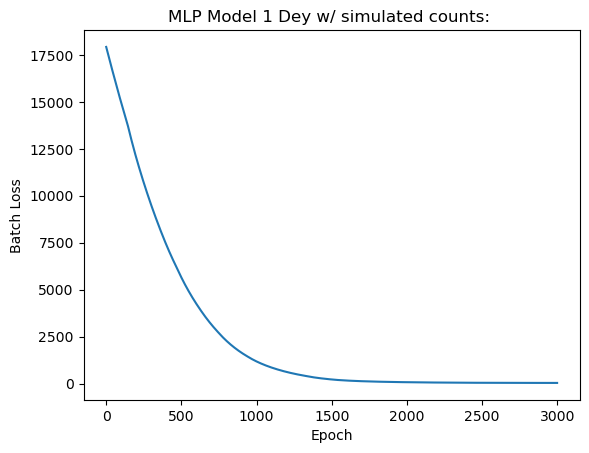

In [57]:
#plt.plot(range(5*n_epochs),loss_trace)
plt.plot(range(n_epochs),avloss_trace)
plt.title(plttitle)
plt.ylabel("Batch Loss")
plt.xlabel("Epoch")
plt.savefig(path+"/MLP_Model1DeyEtAl_loss")

# Calculated vs. Measured Link Counts
- These should be reproduced perfectly from the model

In [55]:
print(path+"/MLP_Model1DeyEtAl_loss")

../OSM/MLP_Model1DeyEtAl_loss


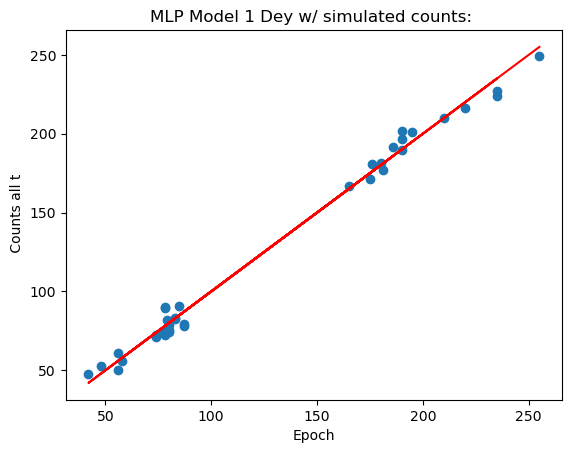

In [58]:
plt.scatter(counts,yhats.T)
plt.plot(counts,counts,"-",color="red")
plt.title(plttitle)
plt.ylabel(" Counts all t")
plt.xlabel("Epoch")
plt.savefig(path+"/MLP_Model1DeyEtAl_counts")
plt.show()

# Route flows from the model
- These are the most likely route flows given the underdetermined system based on link counts

In [59]:
np.set_printoptions(suppress=True)
#out_cpu=outputs.detach().cpu().numpy()
print(f"{np.array2string(out_cpu.T,precision=1, floatmode='fixed')}")
print("-----------------")
print(f"{np.array2string(x.value,precision=1, floatmode='fixed')}")

[[ 60.9  47.9  52.9  49.9  55.9]
 [  0.0   0.0   0.0   0.0   0.0]
 [ 65.3  52.1  56.3  53.5  58.9]
 [  0.0   0.0   0.0   0.0   0.0]
 [ 63.7  50.6  55.6  52.3  58.2]
 [ 23.0  18.0  19.3  18.3  20.2]
 [124.6  98.0 107.6  99.7 112.6]
 [  2.3   2.3   2.9   2.4   2.6]
 [  0.0   0.0   0.0   0.0   0.0]
 [ 26.7  21.8  23.9  23.4  25.0]
 [  0.0   0.0   0.0   0.0   0.0]
 [  0.0   0.0   0.0   0.0   0.0]
 [ 28.8  23.2  25.2  24.4  26.6]
 [ 55.8  43.7  47.1  44.1  49.4]
 [ 79.9  63.5  69.2  65.1  72.4]
 [ 62.1  49.3  54.3  50.1  56.4]]
-----------------
[[  0.0   9.0  10.0  11.0  12.0]
 [ 15.0  14.0  16.0  14.0  15.0]
 [ 20.0  17.0  18.0  17.0  18.0]
 [ 19.0  10.0  12.0  14.0  15.0]
 [ 20.0  19.0  22.0  20.0  21.0]
 [ 28.0  25.0  26.0  25.0  26.0]
 [201.0 138.0 161.0 130.0 173.0]
 [ 37.0  35.0  36.0  35.0  35.0]
 [ 16.0  10.0  12.0  13.0  14.0]
 [ 18.0  17.0  20.0  19.0  20.0]
 [ 21.0  13.0  14.0  18.0  18.0]
 [ 24.0  24.0  29.0  27.0  27.0]
 [ 62.0  55.0  65.0  56.0  58.0]
 [ 53.0  39.0  41.0  40.

### Plot of route flow from MLP vs. integer solver in CVXPY shows bias
- MLP estimates systematic higher flow rates and more 0,s, i.e concentration of flow on routes

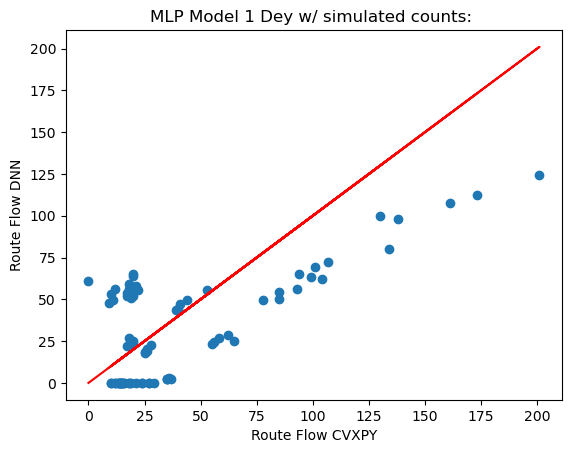

In [60]:
plt.scatter(x.value, out_cpu.T)
plt.plot(x.value, x.value, "-", color="red")
plt.title(plttitle)
plt.ylabel("Route Flow DNN")
plt.xlabel("Route Flow CVXPY")
plt.savefig(path+"/MLP_Model1DeyEtAl_route_flow")

# The OD flows are sums of the route flows over each OD
- They represent the most likely flows given the underdetermined system based on the link counts

In [61]:
#np.set_printoptions(suppress=True)
print(od_pairs)
od_flow_matrix_mlp=od_flow_from_route_flow(od_pairs,out_cpu.T)
print(f"{np.array2string(od_flow_matrix_mlp,precision=1, floatmode='fixed')}")
print("-----------------")
print(od_flow_matrix_x)

[('A', 'F'), ('A', 'C'), ('A', 'E'), ('A', 'B'), ('A', 'D'), ('B', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F'), ('D', 'F'), ('D', 'E'), ('E', 'F')]
0 0 ('A', 'F', '0') [60.94135284 47.91410828 52.90272522 49.89079666 55.92973328] [60.94135284 47.91410828 52.90272522 49.89079666 55.92973328]
0 1 ('A', 'F', '1') [60.94135284 47.91410828 52.90272522 49.89079666 55.92973328] [0. 0. 0. 0. 0.]
0 2 ('A', 'F', '2') [126.24310303  99.99494553 109.18608475 103.42675781 114.86547089] [65.30175018 52.08083725 56.28335953 53.53596115 58.93573761]
1 3 ('A', 'C', '0') [0. 0. 0. 0. 0.] [0. 0. 0. 0. 0.]
2 4 ('A', 'E', '0') [63.70248795 50.59823227 55.56624603 52.26368332 58.24837875] [63.70248795 50.59823227 55.56624603 52.26368332 58.24837875]
2 5 ('A', 'E', '1') [86.66939926 68.5704422  74.84817123 70.51795959 78.40285873] [22.96691132 17.97220993 19.2819252  18.25427628 20.15447998]
3 6 ('A', 'B', '0') [124.55030823  98.04017639 107.60153198  99.74333191 112.62625122] [124.55030823  98.04017639 107.601

### MLP shows higher OD flow for values that are high in CVXPY solution
- and some low, constant values where CVXPY is variable and medium-rate
- and many zero-value flows where CVXPY has low flow rates

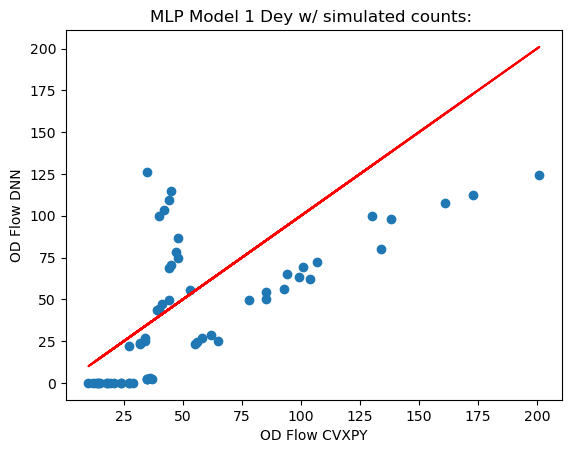

In [63]:
plt.scatter(od_flow_matrix_x,od_flow_matrix_mlp)
plt.plot(od_flow_matrix_x, od_flow_matrix_x, "-",color="red")
plt.title(plttitle)
plt.ylabel("OD Flow DNN")
plt.xlabel("OD Flow CVXPY")
plt.savefig(path+"/MLP_ModelDeyEtAl_od_flow")

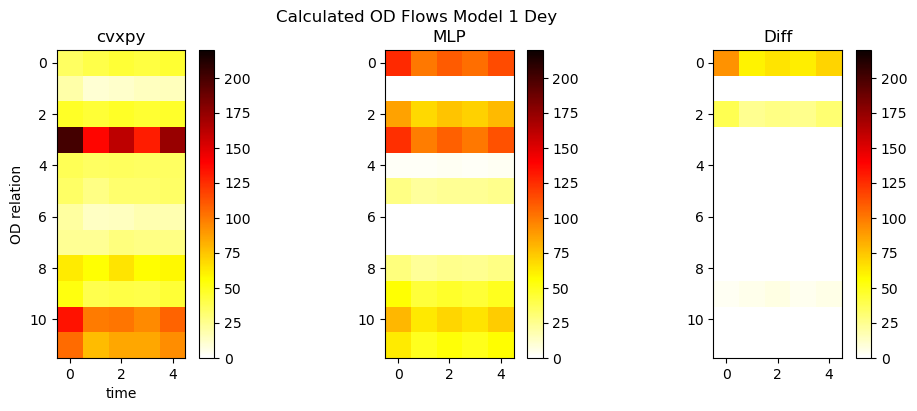

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im1=axes[0].imshow(od_flow_matrix_x, cmap='hot_r', interpolation='nearest',vmin=0, vmax=220)
im2=axes[1].imshow(od_flow_matrix_mlp, cmap='hot_r', interpolation='nearest',vmin=0, vmax=220)
im3=axes[2].imshow(od_flow_matrix_mlp-od_flow_matrix_x, cmap='hot_r', interpolation='nearest',vmin=0, vmax=220)

axes[0].title.set_text('cvxpy')
axes[0].set_ylabel("OD relation")
axes[0].set_xlabel("time")
axes[1].title.set_text("MLP")
axes[2].title.set_text("Diff")

plt.suptitle("Calculated OD Flows Model 1 Dey")
plt.colorbar(im1)
plt.colorbar(im2)
plt.colorbar(im3)
plt.savefig(path+"/MLP_Model1_DeyEtAl_vs_CVXPY_od_heatmap")
plt.show()

# Issues: many 0-value route flows from MLP
### These are centrally-located nodes which are on routes, random which ones though
### Layer Bias = True
- Setting layer bias to true improves agreement with counts and there are fewer 0-value route flows
### Decrease learning rate
- 1e-6 needs 2000 epochs, 5/16 0-values if left to minimize loss (only 2 if 1000 epochs but not min loss)
### Increase learning rate
- 1e-2 fast learning drop in 3 epochs, bumps 5,40 epochs, still 0-value route flows
### Shuffle counts input with Dataloader does this affect order of X outputs?
- Something is really wrong with this result as the counts now also have zeroes
### L1 loss instead of MLE (L2)
- A less-even decrease in loss, slower loss decline, still 5 0-value routes just different ones
- Note L1-loss is "built in" to the system (Khrzansky)
### L1-Regularization with MSE (Lasso) makes many more zeros, sweep lambda
- As in CompressedSensing_1.ipynb
- Regularization is suited for sparse solution
- Best lambda 0.01 (see sweep below)
### Forcing NN to integer-value solutions
- Gradients would be unpredictable
- Round off float results?
- Constrain model and input to UINT for inference on CPU but no training
- Logit/Sigmoid output layer for categorical int output

In [59]:
def run_model(l1_lambda):
# Prepare  dataset

#trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

    Ytorch=torch.from_numpy(counts).float().to(torch_device)# leaf, not requires grad
    print(f"Ytorch is on device: {Ytorch.get_device()}")
    trainloader = torch.utils.data.DataLoader(Ytorch.T)
#trainloader = torch.utils.data.DataLoader(Ytorch.T, batch_size=1, shuffle=False, num_workers=1)


#print(f"Ytorch {Ytorch.grad_fn} {Ytorch.is_leaf}")

# Initialize the MLP
#mlp=MLP(ysize,xsize,l1size,l2size)
    mlp=MLP()
    mlp.to(torch_device)
  #  print(f"mlp is on device: {next(mlp.parameters()).device}")

  #  print(mlp)

# Define the loss function and optimizer
    loss_function = nn.MSELoss()
#loss_function = nn.L1Loss()

    optimizer = torch.optim.Adam(mlp.parameters(), lr=lrate)
#optimizer = torch.optim.SGD(mlp.parameters(), lr=lrate)

# Run the training loop

    loss_trace=[]
    avloss_trace=[]
    yhats=counts.T*0.
    out_cpu=x.value.T*0
    
    for epoch in range(0, n_epochs): # 5 epochs at maximum
        batch_loss=0.  
  # Print epoch
  #if(epoch % 100 == 0):
        #print(f'Starting epoch {epoch+1}')
    
# Train
        for i, data in enumerate(trainloader):# iterate through time steps

            inputs = data.float() # there are no targets/labels
    #print(f"inputs on device: {inputs.get_device()}")
            inputs = inputs.to(torch_device)
    #print(f"inputs cast to device: {inputs.get_device()}")
   
  # Zero the gradients
            optimizer.zero_grad()
      
  # Perform forward pass
    #print(f"Ytorch[:,i] {Ytorch[:,i].grad_fn} {Ytorch[:,i].is_leaf}")
            outputs = mlp(inputs)
  
            Atorch=torch.from_numpy(aij.T).float().to(torch_device) # Transpose adjacency matrix
    
  # Calculate loss
            yhat = (outputs @ Atorch).to(torch_device)# grad, no leaf

  #yhat = torch.tensor(Atorch @ outputs,dtype=torch.float,requires_grad=True).to(device)# no grad, leaf
  #print(f"outputs {outputs.grad_fn} {outputs.is_leaf}")
   # print(f"yhat {yhat.grad_fn} {yhat.is_leaf}")

            loss = loss_function(yhat,inputs)
  # L1 regularization
            l1_norm = sum(torch.linalg.norm(p, 1) for p in mlp.parameters())
            loss = loss + l1_lambda * l1_norm
  #loss=loss_function(outputs,targets)
  
# Perform backward pass
            loss.backward()

# Perform optimization
            optimizer.step()
      
  # Print statistics
            batch_loss += loss.item()
            loss_trace.append(loss.item())
    #print(loss.item())

            if(epoch==n_epochs-1):
                yhats[i,:]=yhat.detach().cpu().numpy()
                out_cpu[i,:]=outputs.detach().cpu().numpy()
        avloss_trace.append(batch_loss/i)
# Process is complete.
    print("Done training")
    return(avloss_trace, yhats, out_cpu)

### Sweep over lambdas for L1 Norm weight

In [60]:
#minloss=9999999.
#for i in range(-5,3):
#    l1_lambda=10.**i
#    v1,v2,v3=run_model(l1_lambda)
#    if(np.min(v1)<minloss):
#        minloss=np.min(v1)
#        minlambda=l1_lambda
#        print(f"minloss {minloss} minlambda {minlambda}")

Ytorch is on device: 0
Done training
minloss 141.09635162353516 minlambda 1e-05
Ytorch is on device: 0
Done training
Ytorch is on device: 0
Done training
minloss 117.44852256774902 minlambda 0.001
Ytorch is on device: 0
Done training
minloss 60.74274682998657 minlambda 0.01
Ytorch is on device: 0
Done training
Ytorch is on device: 0
Done training
Ytorch is on device: 0
Done training
Ytorch is on device: 0
Done training


# Best lamdba is 0.01
# Check that the MLP has learned itself out with the final lambda

Text(0.5, 0, 'Epoch')

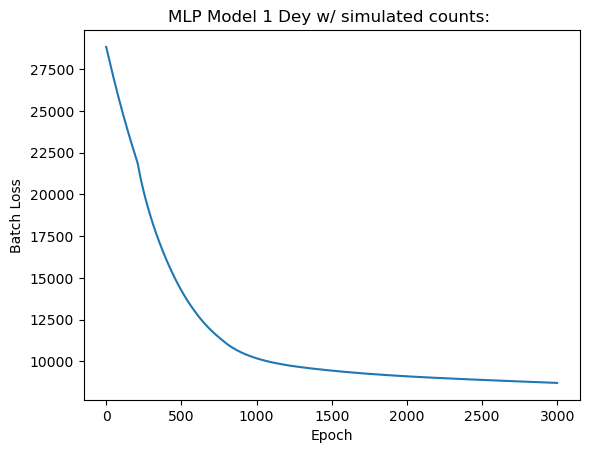

In [61]:
#plt.plot(range(5*n_epochs),loss_trace)
plt.plot(range(n_epochs),v1)
plt.title(plttitle)
plt.ylabel("Batch Loss")
plt.xlabel("Epoch")